# 1-2 Visualize the Optimization Process

In [177]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.nn.utils import parameters_to_vector
from torch.autograd import Variable
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from autograd_lib import autograd_lib
from collections import defaultdict

torch.manual_seed(1)
PROJECT_PATH = "files/"

In [178]:
# Get MNIST Data Files
def get_data_loaders(batch_size):
    transform = transforms.ToTensor()
    
    train_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

print(f"Train dataset size: {len(torchvision.datasets.MNIST(root='./data', train=True))}")
print(f"Test dataset size: {len(torchvision.datasets.MNIST(root='./data', train=False))}")

Train dataset size: 60000
Test dataset size: 10000


In [179]:
# Model Definition
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

model = DNN()
print(f'Total number of parameters: {count_parameters(model)}')

Total number of parameters: 476490


In [180]:
# Training & Testing Functions
def train_model(model, num_epochs, train_loader, optimizer, criterion, status_interval):
    model.train()
    history = {'epoch': [], 'loss': [], 'acc': []}
    weight_history = pd.DataFrame()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images), Variable(labels)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % status_interval == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end='\r')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        history['epoch'].append(epoch + 1)
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        
        # Collect weights
        epoch_weights = pd.DataFrame()
        for name, param in model.named_parameters():
            if 'weight' in name:
                weights = parameters_to_vector(param).detach().numpy()
                epoch_weights = pd.concat([epoch_weights, pd.DataFrame(weights).T], axis=1)
        
        weight_history = pd.concat([weight_history, epoch_weights], axis=0)
    
    return history, weight_history

def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = Variable(images), Variable(labels)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    
    print(f'Test Accuracy: {accuracy:.2f}% | Test Loss: {avg_loss:.4f}')
    return accuracy, avg_loss

In [181]:
MAX_EPOCHS = 45
ITERATIONS = 8
BATCH_SIZE = 1000
STATUS_INTERVAL = 60

criterion = nn.CrossEntropyLoss()
all_weights = pd.DataFrame()
results = {'train_acc': {}, 'train_loss': {}, 'test_acc': {}, 'test_loss': {}}

for iteration in range(ITERATIONS):
    print(f"Iteration: {iteration + 1}")
    
    model = DNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    
    train_loader, test_loader = get_data_loaders(BATCH_SIZE)
    
    history, weight_history = train_model(model, MAX_EPOCHS, train_loader, optimizer, criterion, STATUS_INTERVAL)
    test_acc, test_loss = test_model(model, test_loader, criterion)
    
    all_weights = pd.concat([all_weights, weight_history], axis=0)
    results['train_acc'][iteration] = history['acc']
    results['train_loss'][iteration] = history['loss']
    results['test_acc'][iteration] = test_acc
    results['test_loss'][iteration] = test_loss

print(all_weights)

Iteration: 1
Test Accuracy: 97.94% | Test Loss: 0.0730
Iteration: 2
Test Accuracy: 98.00% | Test Loss: 0.0667
Iteration: 3
Test Accuracy: 97.92% | Test Loss: 0.0755
Iteration: 4
Test Accuracy: 97.95% | Test Loss: 0.0705
Iteration: 5
Test Accuracy: 98.01% | Test Loss: 0.0699
Iteration: 6
Test Accuracy: 98.04% | Test Loss: 0.0670
Iteration: 7
Test Accuracy: 97.93% | Test Loss: 0.0708
Iteration: 8
Test Accuracy: 97.98% | Test Loss: 0.0753
             0             1             2             3             4    \
0   3.367198e-04 -9.492148e-06 -8.885182e-03  4.893781e-03 -6.773273e-03   
0  -3.453659e-06 -5.559185e-07 -6.024116e-04 -6.597794e-05 -1.593573e-04   
0   2.783990e-07  6.943521e-09  2.062136e-05  8.774761e-07  1.283876e-05   
0  -3.105287e-08 -8.445592e-10 -4.633717e-07 -1.513569e-07 -5.683699e-07   
0  -4.178158e-10  4.309543e-11  1.715323e-08  1.489263e-08  1.976847e-08   
..           ...           ...           ...           ...           ...   
0   3.397022e-39  9.095397e-

In [182]:
# Data Processing for Visualization
def process_data_for_pca(data, num_components=2):
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(data)
    return pca_result

def create_visualization_df(pca_result, epochs, iterations, acc_data, loss_data):
    df = pd.DataFrame(pca_result, columns=['x', 'y'])
    df['Epoch'] = [i for i in range(epochs)] * iterations
    df['Iteration'] = np.repeat([i for i in range(iterations)], epochs)
    df['Accuracy'] = acc_data
    df['Loss'] = loss_data
    return df

pca_result = process_data_for_pca(all_weights)
train_acc_data = np.array(pd.DataFrame(results['train_acc'])).flatten()
train_loss_data = np.array(pd.DataFrame(results['train_loss'])).flatten()

visualization_df = create_visualization_df(pca_result, MAX_EPOCHS, ITERATIONS, train_acc_data, train_loss_data)
print(visualization_df)

             x          y  Epoch  Iteration   Accuracy      Loss
0    -1.596803  -8.943196      0          0  69.635000  1.201939
1    -1.878429 -10.386534      1          0  66.188333  1.209939
2    -2.090380 -11.488654      2          0  71.570000  1.208832
3    -2.263279 -12.377526      3          0  69.851667  1.161447
4    -2.404251 -13.097409      4          0  67.553333  1.205804
..         ...        ...    ...        ...        ...       ...
355  13.948720  -3.476312     40          7  99.990000  0.003992
356  13.865734  -3.457679     41          7  99.971667  0.004510
357  13.777465  -3.432498     42          7  99.988333  0.004110
358  13.696314  -3.410986     43          7  99.973333  0.004807
359  13.615079  -3.394429     44          7  99.978333  0.004807

[360 rows x 6 columns]


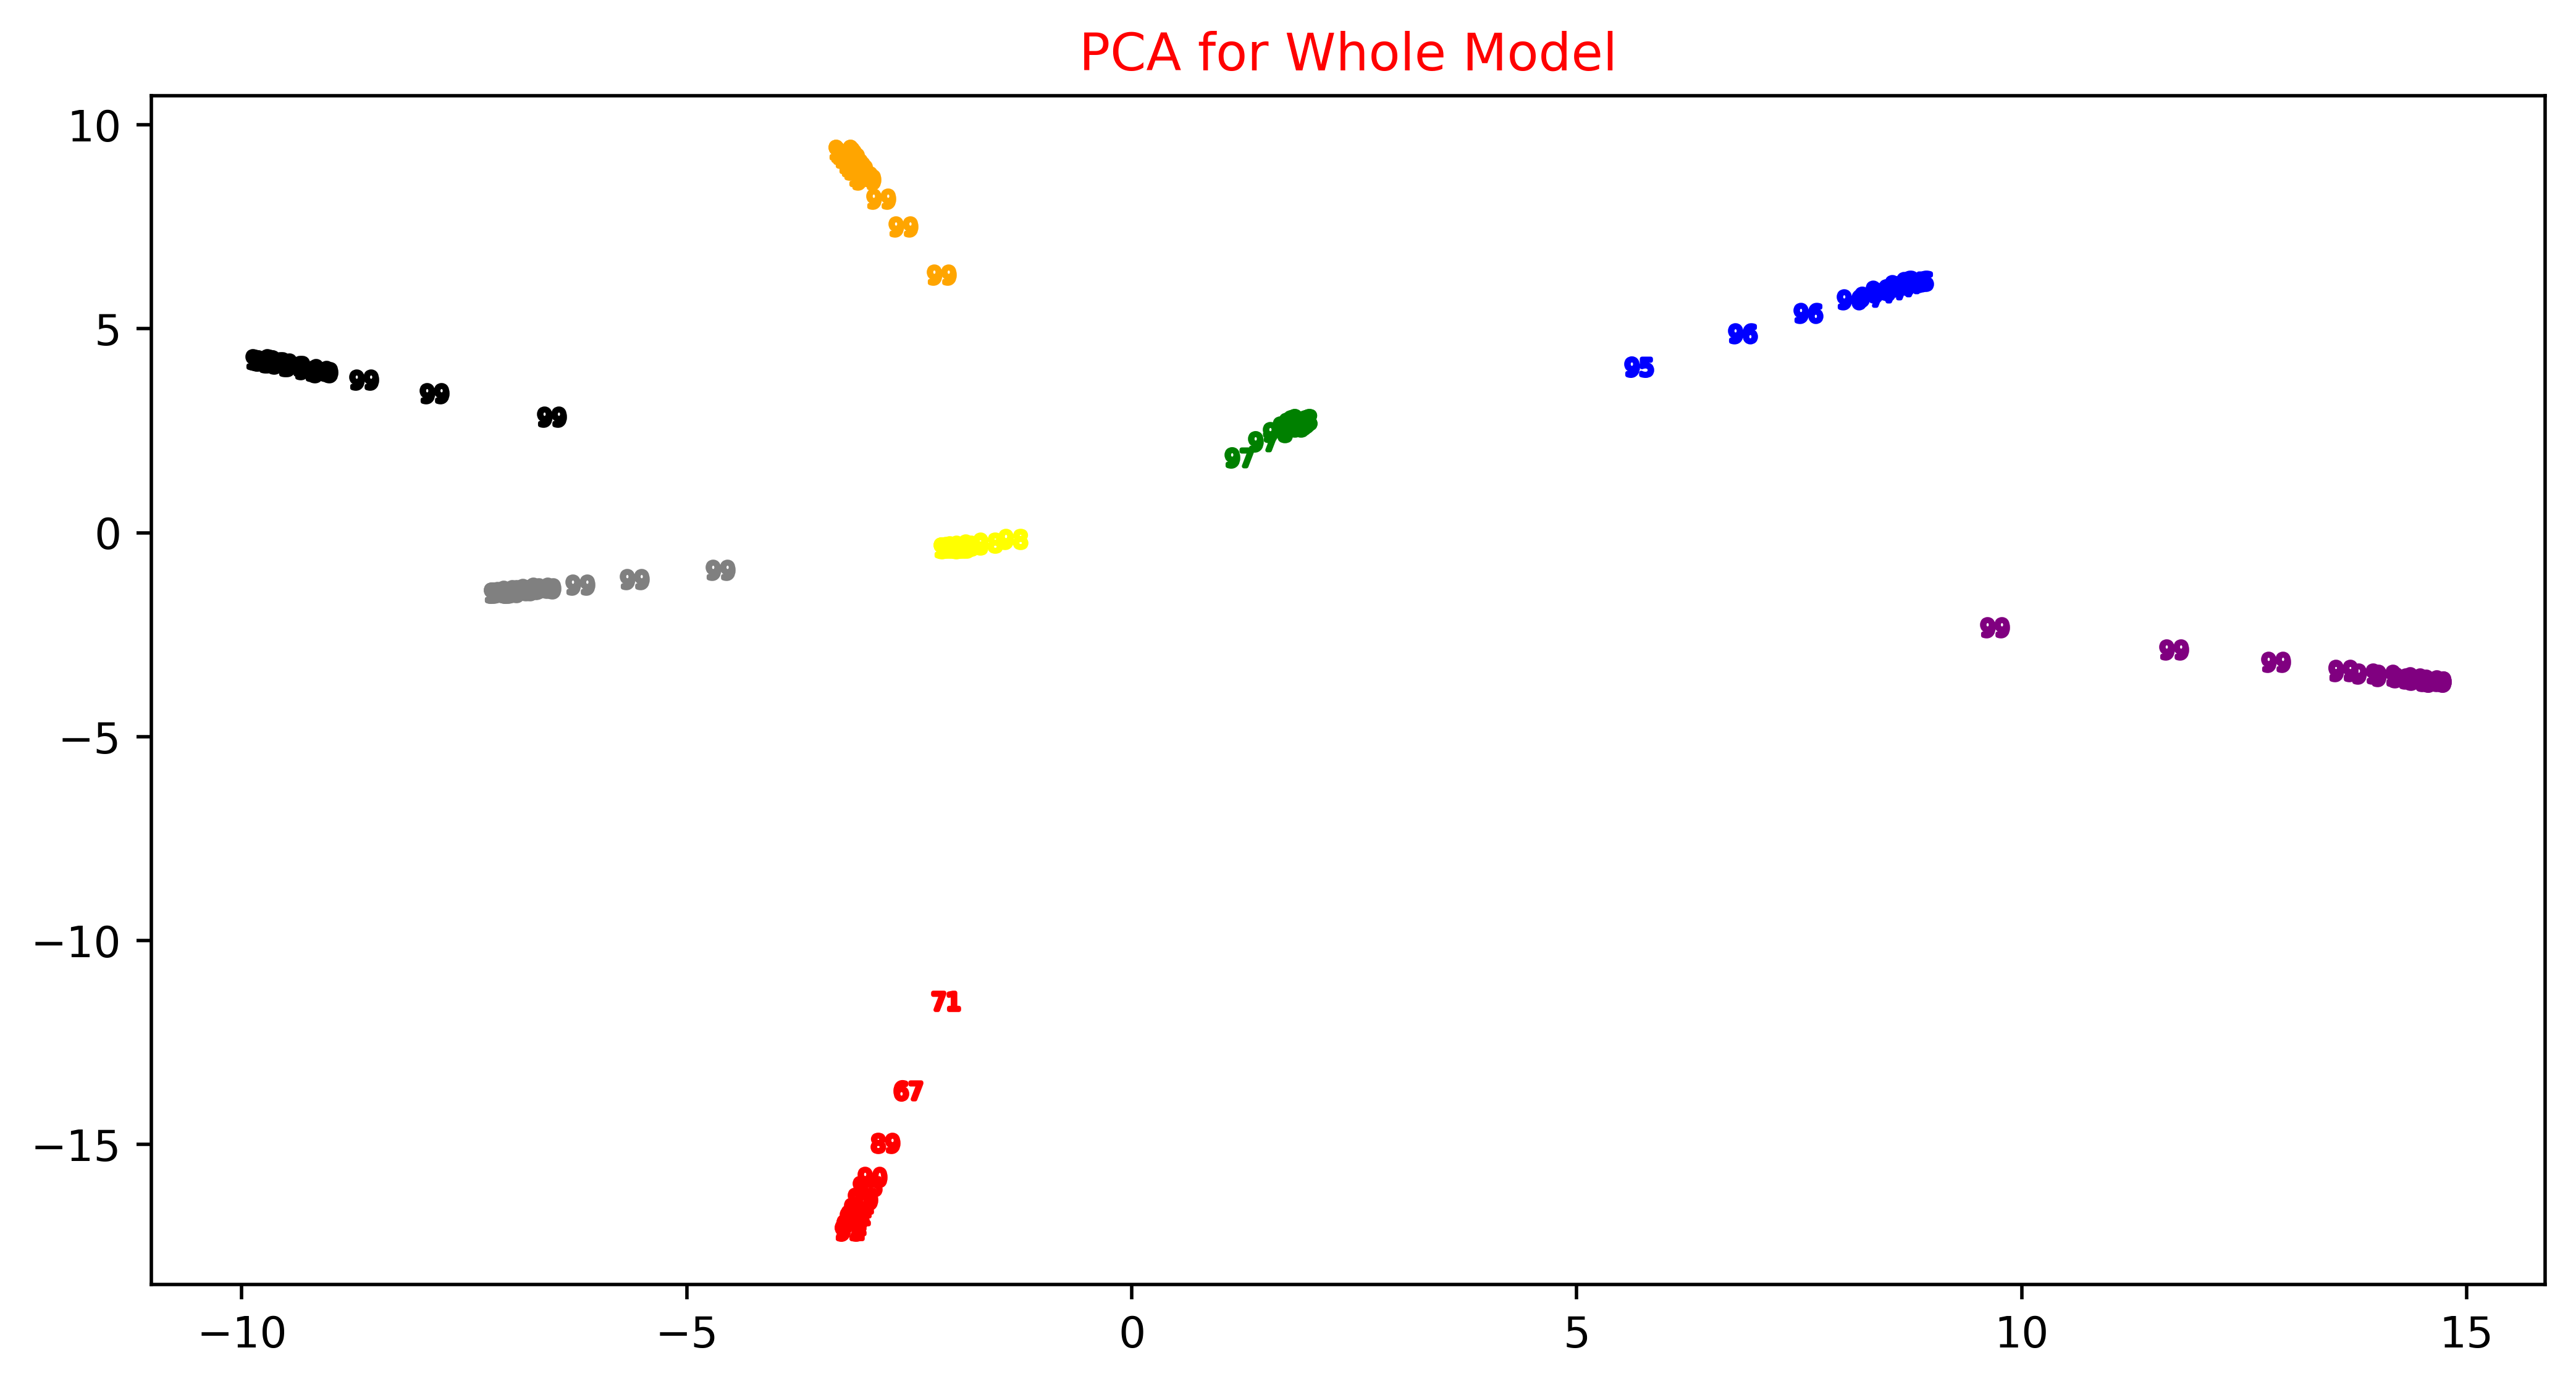

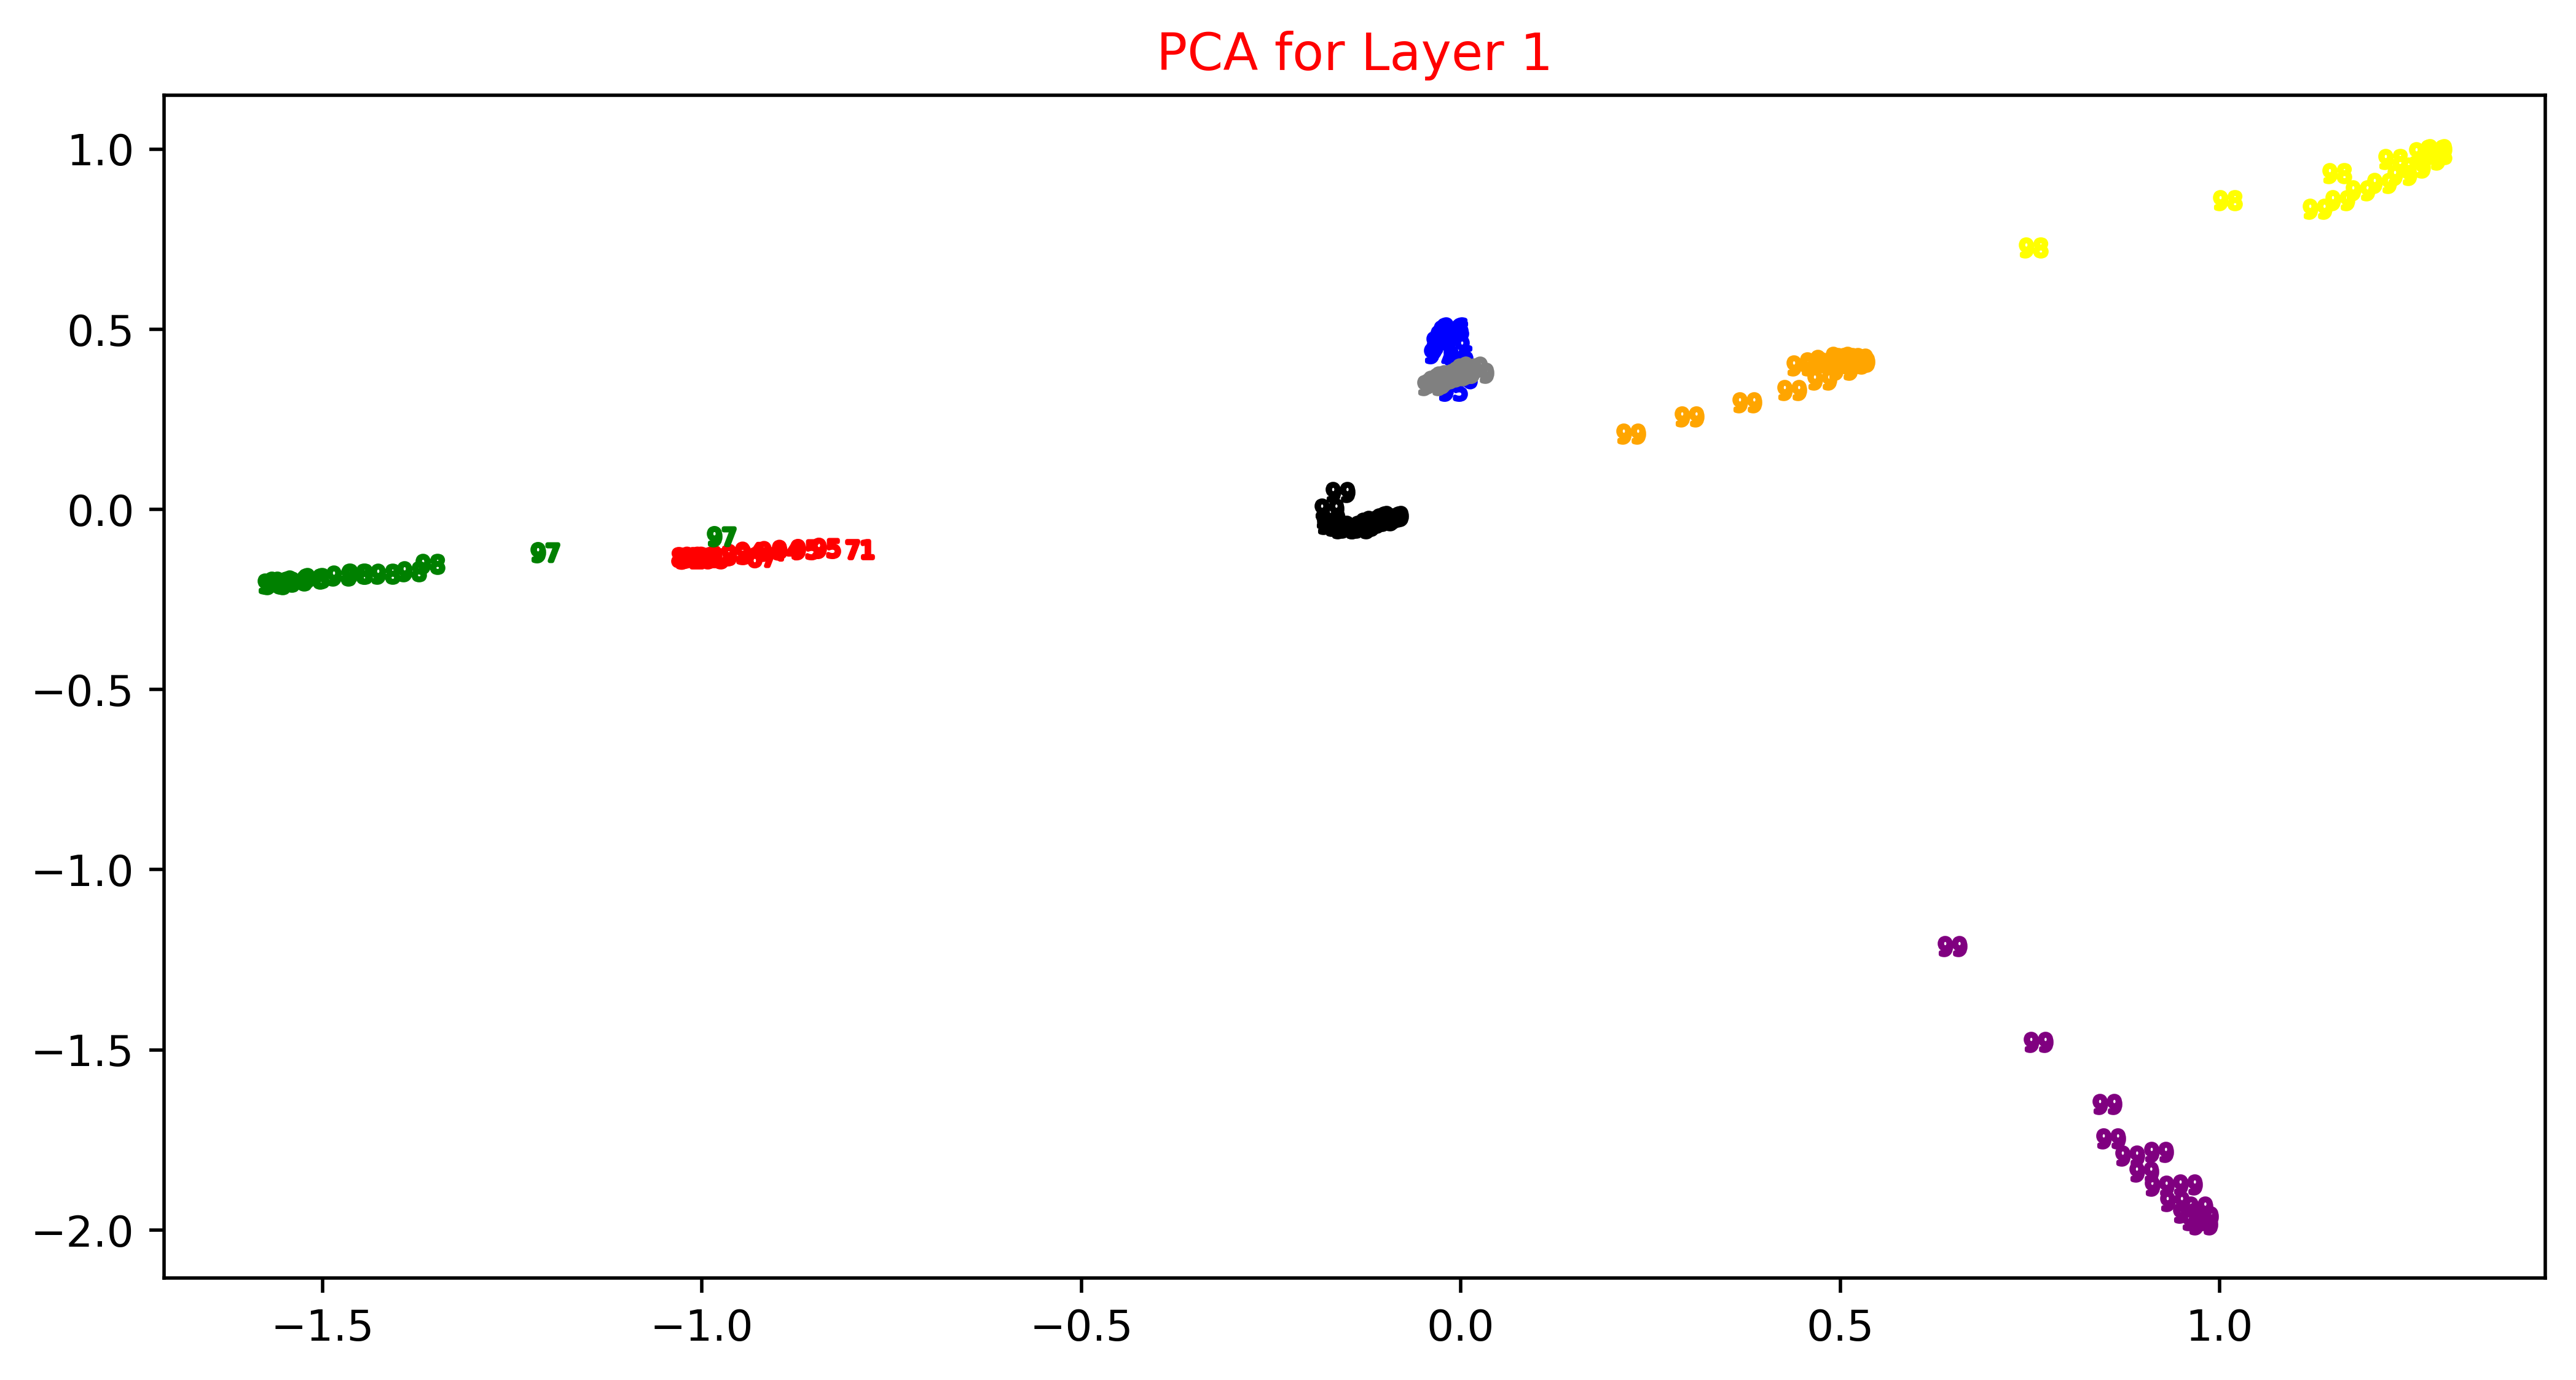

In [183]:
# Visualization
def plot_pca_results(df, title, output_path):
    plt.figure(figsize=(10, 5), dpi=500)
    color_arr = ['red', 'blue', 'green', 'yellow', 'orange', 'black', 'grey', 'purple']
    
    for i, row in df.iterrows():
        plt.scatter(row['x'], row['y'], marker=f"${int(row['Accuracy'])}$", color=color_arr[int(row['Iteration'])])
    
    plt.title(title, color="r")
    plt.savefig(output_path, format='pdf', dpi=700, bbox_inches='tight')
    plt.show()

# Plot for whole model
plot_pca_results(visualization_df[visualization_df['Epoch'] % 3 == 2], "PCA for Whole Model", f"{PROJECT_PATH}/pca_whole_model.pdf")

# Plot for first layer
layer1_weights = all_weights.iloc[:, :7840]
layer1_pca = process_data_for_pca(layer1_weights)
layer1_df = create_visualization_df(layer1_pca, MAX_EPOCHS, ITERATIONS, train_acc_data, train_loss_data)
plot_pca_results(layer1_df[layer1_df['Epoch'] % 3 == 2], "PCA for Layer 1", f"{PROJECT_PATH}/pca_layer1.pdf")

### Observe Gradient Norm During Training

In [184]:
# Model Definition
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [185]:
# Training Functions
def train_model(net, loss_fn, optimizer, inputs, targets):
    MAX_EPOCHS = 2500
    epochs, losses = [], []
    epoch_count = 0
    gradient_history = []
    
    for epoch_count in range(1, MAX_EPOCHS + 1):
        # Forward pass
        output = net(inputs)
        current_loss = loss_fn(output, targets)
        
        # Backpropagation
        optimizer.zero_grad()
        current_loss.backward()
        
        epochs.append(epoch_count)
        losses.append(current_loss.detach().numpy())
        
        # Calculate gradient norm
        total_grad = sum((p.grad.cpu().data.numpy()**2).sum() 
                         for p in net.parameters() if p.grad is not None)
        grad_norm = np.sqrt(total_grad)
        
        optimizer.step()
        gradient_history.append(grad_norm)
        
        # Logging
        if epoch_count % 100 == 0:
            print(f'Epoch: {epoch_count}, Loss: {current_loss.item():.4f}, Gradient Norm: {grad_norm}')
    
    print(f"Completed {MAX_EPOCHS} epochs")
    return epochs, losses, output, grad_norm, gradient_history

In [186]:
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
y = torch.sin(5 * torch.pi * x) / (5 * torch.pi * x)
print('Xshape:', x.shape, "\nYshape:", y.shape)

x, y = x.clone().detach().float(), y.clone().detach().float()
n_samples, n_features = x.shape

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

a = []
for i in model.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', sum(a))

epoch_arr, loss_arr, prediction, grad_norm, grad_arr = train_model(model, criterion, optimizer, x, y)

Xshape: torch.Size([300, 1]) 
Yshape: torch.Size([300, 1])
Total no of parameters in Model 1: 41729
Epoch: 100, Loss: 0.0128, Gradient Norm: 0.031734563410282135
Epoch: 200, Loss: 0.0025, Gradient Norm: 0.03806208819150925
Epoch: 300, Loss: 0.0008, Gradient Norm: 0.015503285452723503
Epoch: 400, Loss: 0.0005, Gradient Norm: 0.09777888655662537
Epoch: 500, Loss: 0.0003, Gradient Norm: 0.0028252163901925087
Epoch: 600, Loss: 0.0003, Gradient Norm: 0.1034589484333992
Epoch: 700, Loss: 0.0003, Gradient Norm: 0.11226697266101837
Epoch: 800, Loss: 0.0002, Gradient Norm: 0.003846758045256138
Epoch: 900, Loss: 0.0002, Gradient Norm: 0.0064849560149014
Epoch: 1000, Loss: 0.0001, Gradient Norm: 0.0032883549574762583
Epoch: 1100, Loss: 0.0001, Gradient Norm: 0.02203625626862049
Epoch: 1200, Loss: 0.0001, Gradient Norm: 0.05533456429839134
Epoch: 1300, Loss: 0.0001, Gradient Norm: 0.004280224442481995
Epoch: 1400, Loss: 0.0001, Gradient Norm: 0.002963598584756255
Epoch: 1500, Loss: 0.0001, Gradien

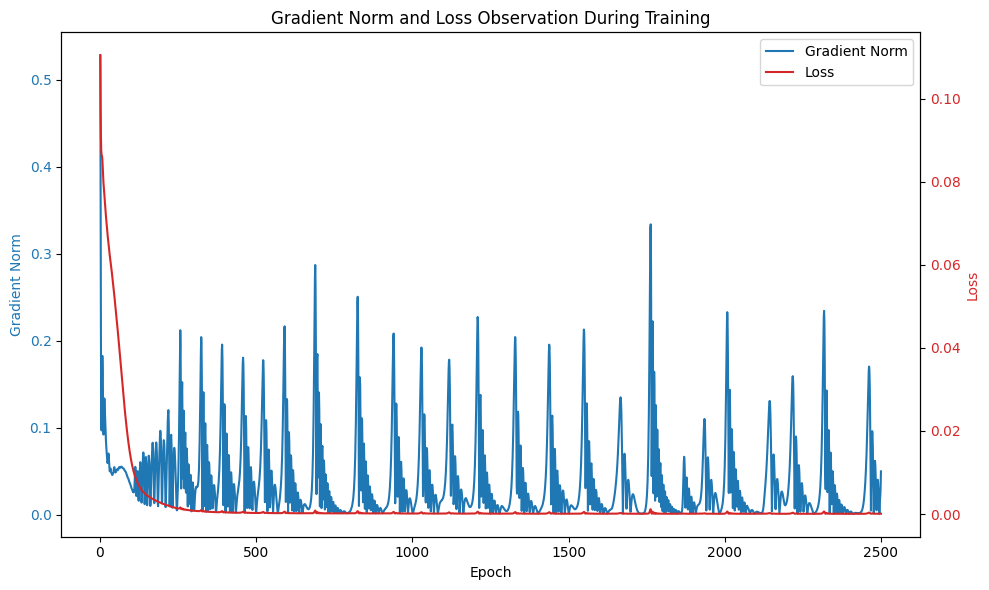

In [187]:

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Gradient Norm', color=color)
ax1.plot(epoch_arr, grad_arr, color=color, label='Gradient Norm')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(epoch_arr, loss_arr, color=color, label='Loss')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gradient Norm and Loss Observation During Training')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.savefig(PROJECT_PATH + '/GradientNorm_and_Loss.pdf', dpi=700, bbox_inches='tight')
plt.show()

#### 2. When The Gradient is Almost Zero

In [188]:
# Define the target function
target_func = lambda x: (torch.sin(5 * np.pi * x)) / (5 * np.pi * x)

# Generate the dataset
num_samples = 300
X = torch.unsqueeze(torch.linspace(-1, 1, num_samples), dim=1)
Y = target_func(X)

# Create the dataset and dataloader
dataset = TensorDataset(X, Y)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [189]:
# Define the first model architecture
class Model(nn.Module):
    def __init__(self, hidden_size=128):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(1, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def compute_training_loss(self, data_batch, loss_function):
        features, labels = data_batch
        predictions = self(features)
        loss = loss_function(predictions, labels)
        return loss

    def compute_validation_loss(self, data_batch, loss_function):
        features, labels = data_batch
        predictions = self(features)
        loss = loss_function(predictions, labels)
        return {'validation_loss': loss.detach()}

    def summarize_validation_epoch(self, batch_results):
        loss_values = [result['validation_loss'] for result in batch_results]
        mean_loss = torch.stack(loss_values).mean()
        return {'validation_loss': mean_loss.item()}

    def compute_training_batch_loss(self, data_batch, loss_function):
        features, labels = data_batch
        predictions = self(features)
        loss = loss_function(predictions, labels)
        return {'batch_loss': loss.detach()}

    def summarize_training_epoch(self, batch_results):
        loss_values = [result['batch_loss'] for result in batch_results]
        mean_loss = torch.stack(loss_values).mean()
        return {'training_loss': mean_loss.item()}

    def log_epoch_results(self, epoch_number, epoch_stats):
        print(f"Epoch {epoch_number}: Validation Loss = {epoch_stats['validation_loss']:.4f}")


In [190]:
def calculate_gradient_magnitude(network, loss_function, inputs, targets):
    network.train()
    network.zero_grad()
    predictions = network(inputs)
    error = loss_function(predictions, targets)
    error.backward()

    gradient_magnitudes = [param.grad.norm(2).item() for param in network.parameters() if param.grad is not None]
    return np.mean(gradient_magnitudes)

def store_layer_output(layer, output, _):
    layer_outputs[layer] = output

def accumulate_hessian(layer, _, grad_output):
    output = layer_outputs[layer]
    outer_product = torch.einsum('nl,ni->nli', grad_output, output)
    hessian_components[layer] += torch.einsum('nli,nkj->likj', outer_product, outer_product)

def estimate_positive_curvature_ratio(network, loss_function, inputs, targets):
    network.zero_grad()
    with autograd_lib.module_hook(store_layer_output):
        predictions = network(inputs)
        error = loss_function(predictions, targets)

    with autograd_lib.module_hook(accumulate_hessian):
        autograd_lib.backward_hessian(predictions, loss='LeastSquares')

    positive_ratios = []
    for h in hessian_components.values():
        flattened_size = h.shape[0] * h.shape[1]
        h_flat = h.reshape(flattened_size, flattened_size)
        eigenvalues = torch.linalg.eigvalsh(h_flat, UPLO='L')
        positive_ratio = torch.sum(eigenvalues > 0).item() / len(eigenvalues)
        positive_ratios.append(positive_ratio)

    return np.mean(positive_ratios)

def compute_gradient_and_curvature_metrics(network, loss_function):
    grad_magnitude = calculate_gradient_magnitude(network, loss_function, X, Y)
    curvature_ratio = estimate_positive_curvature_ratio(network, loss_function, X, Y)
    print(f'Gradient magnitude: {grad_magnitude}, Positive curvature ratio: {curvature_ratio}')
    return {"gradient_magnitude": grad_magnitude, "curvature_ratio": curvature_ratio}

def assess_validation_performance(network, loss_function, val_data):
    results = [network.compute_validation_loss(batch, loss_function) for batch in val_data]
    return network.summarize_validation_epoch(results)

def assess_training_performance(network, loss_function, train_data):
    results = [network.train_step(batch, loss_function) for batch in train_data]
    return network.train_epoch_end(results)

def calculate_gradient_norm(network):
    total_grad_squared = sum((p.grad.cpu().data.numpy()**2).sum() for p in network.parameters() if p.grad is not None)
    return total_grad_squared ** 0.5

def assess_validation_performance(network, loss_function, val_data):
    results = [network.compute_validation_loss(batch, loss_function) for batch in val_data]
    return network.summarize_validation_epoch(results)

def assess_training_performance(network, loss_function, train_data):
    results = [network.train_step(batch, loss_function) for batch in train_data]
    return network.train_epoch_end(results)

def train_network(num_epochs, learning_rate, network, data_loader, loss_function, optimizer_class):
    performance_history = []
    gradient_metrics = {}
    optimizer = optimizer_class(network.parameters(), learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        predictions = network(X)
        loss = loss_function(predictions, Y)
        loss.backward()

        gradient_metrics[epoch] = compute_gradient_and_curvature_metrics(network, loss_function)
        optimizer.step()
        optimizer.zero_grad()

        epoch_result = assess_validation_performance(network, loss_function, data_loader)
        network.log_epoch_results(epoch, epoch_result)
        performance_history.append(epoch_result)

    return performance_history, gradient_metrics, network

In [191]:
# Training configuration
lr = 0.0005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs = 2500

# Initialize the model and register with autograd_lib for Hessian computation
model = Model()
autograd_lib.register(model)

# Activation and Hessian tracking
layer_outputs = defaultdict(int)
hessian_components = defaultdict(float)

# Evaluate the model before training
result_1 = assess_validation_performance(model, criterion, data_loader)

c:\Users\elrod\anaconda3\envs\test2\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [192]:
# Define another model architecture (Model2)
class Model2(torch.nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.input = torch.nn.Linear(1, 5)
        self.fc1 = torch.nn.Linear(5, 10)
        self.fc2 = torch.nn.Linear(10, 5)
        self.output = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = F.leaky_relu(self.input(x))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))

        return self.output(x)

In [193]:
# Train the model and collect gradient norm history
model2 = Model2()
history, grad_norm_history, model = train_network(num_epochs, lr, model, data_loader, criterion, optimizer)

# Gather validation losses and minimal ratio for each epoch
val_losses = [r['validation_loss'] for r in history]
minimal_ratios = [i['curvature_ratio'] for i in grad_norm_history.values()]

Gradient magnitude: 0.38363778218626976, Positive curvature ratio: 0.66796875
Epoch 0: Validation Loss = 0.1390
Gradient magnitude: 0.4243668466806412, Positive curvature ratio: 0.73046875
Epoch 1: Validation Loss = 0.1426
Gradient magnitude: 0.46797032840549946, Positive curvature ratio: 0.71875
Epoch 2: Validation Loss = 0.1469
Gradient magnitude: 0.5138527732342482, Positive curvature ratio: 0.7109375
Epoch 3: Validation Loss = 0.1519
Gradient magnitude: 0.5613766014575958, Positive curvature ratio: 0.703125
Epoch 4: Validation Loss = 0.1576
Gradient magnitude: 0.6102044880390167, Positive curvature ratio: 0.7265625
Epoch 5: Validation Loss = 0.1640
Gradient magnitude: 0.660070825368166, Positive curvature ratio: 0.69140625
Epoch 6: Validation Loss = 0.1711
Gradient magnitude: 0.7107720337808132, Positive curvature ratio: 0.7265625
Epoch 7: Validation Loss = 0.1789
Gradient magnitude: 0.7621269077062607, Positive curvature ratio: 0.72265625
Epoch 8: Validation Loss = 0.1874
Gradient

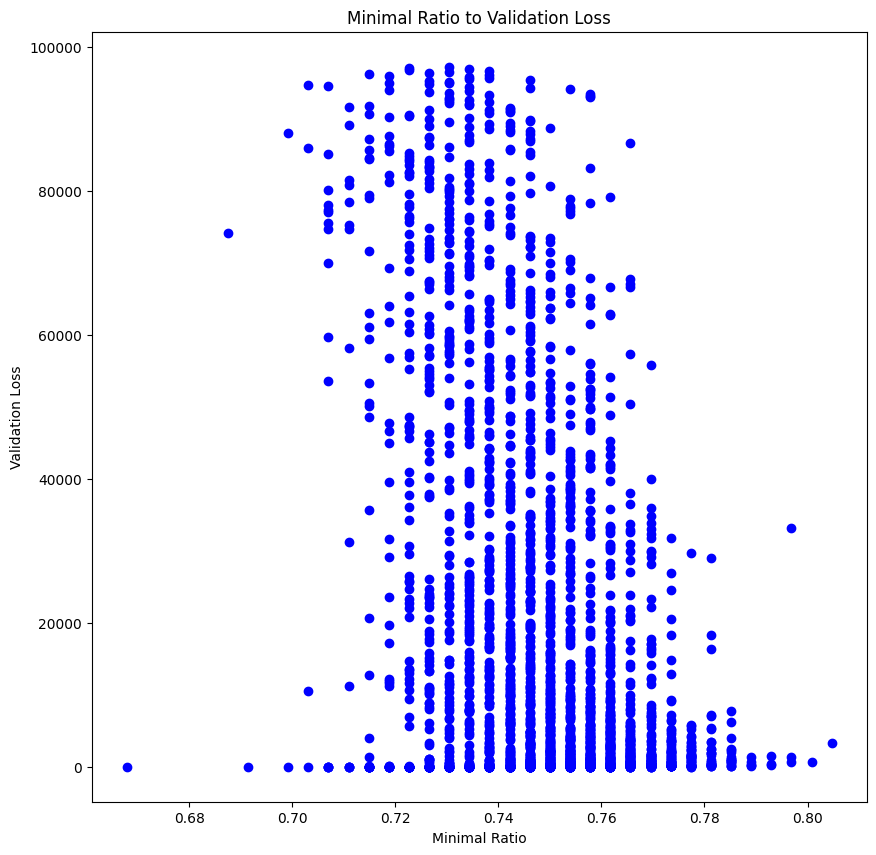

In [194]:
# Plot minimal ratio vs validation loss
plt.figure(figsize=(10, 10))
plt.scatter(minimal_ratios, val_losses, color='blue')
plt.xlabel('Minimal Ratio')
plt.ylabel('Validation Loss')
plt.title('Minimal Ratio to Validation Loss')
plt.savefig(PROJECT_PATH + '/gradient.pdf', dpi=700, bbox_inches='tight')
plt.savefig(PROJECT_PATH + "minimal_ratio_loss.png")